## 라이브러리 import 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
# 재현성을 위한 코드
random_seed = 777

tf.keras.utils.set_random_seed(random_seed)
# tf.random.normal([5], 0, 1)

## 데이터 불러오기

In [3]:
# 레이블 불러오기
TrainLabel = np.array(pd.read_csv('./ProcessedData/TrainLabel.csv', sep = ",", header = None))
ValidLabel = np.array(pd.read_csv('./ProcessedData/ValidLabel.csv', sep = ",", header = None))

TrainLabel.shape, ValidLabel.shape

((300, 2), (60, 2))

In [4]:
# 데이터 갯수, 길이 정의

NoOfData  = 180                    # 데이터 개수 (정상/고장 각각)
NoOfValid = int(NoOfData/6)        # 검증 데이터 개수
NoOftrain = NoOfData - NoOfValid   # 학습 데이터 개수
DataLength = 2774                  # 데이터 길이
NoOfSensor = 1                     # 센서 개수

NoOfData, NoOfValid, NoOftrain, DataLength, NoOfSensor

(180, 30, 150, 2774, 1)

In [5]:
# 전체 가속도 데이터 만들기

TotalData = np.zeros([NoOfData*2, DataLength]) # 데이터 빈집

for i in range(NoOfData):
    tempNormalPath   = './SpotWeldingData/Normal_%d.csv'%(i+1)
    tempAbnormalPath = './SpotWeldingData/Abnormal_%d.csv'%(i+1)
    tempNormal   = pd.read_csv(tempNormalPath  ).iloc[:,0]  # 가속도 데이터
    tempAbnormal = pd.read_csv(tempAbnormalPath).iloc[:,0]  # 가속도 데이터
    TotalData[i,:]            = tempNormal
    TotalData[i + NoOfData,:] = tempAbnormal

TotalData.shape

(360, 2774)

In [6]:
# Data Reshape for CNN
TotalData = TotalData.reshape(TotalData.shape[0], TotalData.shape[1], NoOfSensor)
print("Reshape_for_CNN Result :", TotalData.shape)

Reshape_for_CNN Result : (360, 2774, 1)


## 학습 데이터와 검증 데이터 분할

In [7]:
# 정상/고장 데이터 분할

Normal   = TotalData[:NoOfData, :, :]
Abnormal = TotalData[NoOfData:, :, :]

Normal.shape, Abnormal.shape

((180, 2774, 1), (180, 2774, 1))

In [8]:
# 정상 및 고장 별 학습/검증 데이터 분할

Normal_train   = Normal[  :NoOftrain, :, :]
Abnormal_train = Abnormal[:NoOftrain, :, :]

Normal_valid   = Normal[  NoOftrain:, :, :]
Abnormal_valid = Abnormal[NoOftrain:, :, :]

Normal_train.shape, Abnormal_train.shape, Normal_valid.shape, Abnormal_valid.shape

((150, 2774, 1), (150, 2774, 1), (30, 2774, 1), (30, 2774, 1))

In [9]:
# 학습 및 검증 데이터 분할

TrainData = np.concatenate([Normal_train, Abnormal_train], axis = 0)
ValidData = np.concatenate([Normal_valid, Abnormal_valid], axis = 0)

TrainData.shape, ValidData.shape

((300, 2774, 1), (60, 2774, 1))

## CNN(Convolution Neural Network) hyperparameter 설정

In [10]:
learningRate  = 0.001
Epoch         = 500

## Keras 기반 CNN 구조(Architecture) 설계

In [11]:
def CNN(input_data):
    keras.backend.clear_session()
    tf.keras.utils.set_random_seed(random_seed)

    model = keras.Sequential()
    model.add(keras.layers.InputLayer(shape=(input_data.shape[1], input_data.shape[2])))                       # Input layer
    model.add(keras.layers.Conv1D(filters = 4, kernel_size=3, strides=1, padding='same', activation=keras.activations.relu,))  # Convolution layer 1
    model.add(keras.layers.MaxPooling1D(pool_size = 2, strides=2))                                             # Pooling layer 1
    model.add(keras.layers.Conv1D(filters = 8, kernel_size=3, strides=1, padding='same', activation=keras.activations.relu))   # Convolution layer 2
    
    # Convolution/Pooling layer to Output layer
    model.add(keras.layers.GlobalAveragePooling1D())                                                           # Global Average Pooling (Simple Structure)

    model.add(keras.layers.Dense(units = 2, activation=keras.activations.softmax))                             # Output Layer

    model.compile(optimizer= keras.optimizers.Adam(learning_rate = learningRate),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

## CNN(Convolution Neural Network) 학습 및 평가 방법

In [12]:
# 모델 만들기
CNN_model = CNN(TrainData)

# 모델 구조, 파라미터 개수 확인
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 2774, 4)             │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1387, 4)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1387, 8)             │             104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 138 (552.00 B)

 Trainable params: 138 (552.00 B)

 Non-trainable params: 0 (0.00 B)

## Keras 기반 CNN 학습 및 평가

In [13]:
# 모델 학습/검증
hist = CNN_model.fit(TrainData, TrainLabel, epochs=Epoch, verbose = 1)
Loss, Accuracy = CNN_model.evaluate(TrainData,  TrainLabel, verbose=0)

print('Final Loss and Accuracy: {:.4f}, {:.2f}%'.format(Loss, Accuracy*100))

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5460 - loss: 0.6980
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5460 - loss: 0.6956
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5460 - loss: 0.6946
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5460 - loss: 0.6941
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4994 - loss: 0.6937
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4540 - loss: 0.6933
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4540 - loss: 0.6929
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4540 - loss: 0.6924
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4540 - loss: 0.6918
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4540 - loss: 0.6912
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4540 - loss: 0.6904
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9333 - loss: 0.4783
Epoch 69/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9333 - loss: 0.4747
Epoch 70/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9333 - loss: 0.4711
Epoch 71/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9333 - loss: 0.4675
Epoch 72/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9333 - loss: 0.4639
Epoch 73/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9333 - loss: 0.4604
Epoch 74/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9333 - loss: 0.4569
Epoch 75/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9333 - loss: 0.4534
Epoch 76/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9333 - loss: 0.4499
Epoch 77/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9391 - loss: 0.4464
Epoch 78/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9391 - loss: 0.4429
Epoch 79/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - ac

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9418 - loss: 0.2812
Epoch 136/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9418 - loss: 0.2792
Epoch 137/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9418 - loss: 0.2772
Epoch 138/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9418 - loss: 0.2752
Epoch 139/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9418 - loss: 0.2733
Epoch 140/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9418 - loss: 0.2713
Epoch 141/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9418 - loss: 0.2694
Epoch 142/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9418 - loss: 0.2676
Epoch 143/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9418 - loss: 0.2657
Epoch 144/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9418 - loss: 0.2639
Epoch 145/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9418 - loss: 0.2621
Epoch 146/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/s

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9440 - loss: 0.1918
Epoch 203/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9440 - loss: 0.1909
Epoch 204/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9440 - loss: 0.1902
Epoch 205/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9440 - loss: 0.1894
Epoch 206/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9440 - loss: 0.1886
Epoch 207/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9440 - loss: 0.1878
Epoch 208/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9461 - loss: 0.1871
Epoch 209/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9461 - loss: 0.1863
Epoch 210/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9461 - loss: 0.1856
Epoch 211/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9461 - loss: 0.1848
Epoch 212/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9461 - loss: 0.1841
Epoch 213/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9514 - loss: 0.1545
Epoch 270/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9514 - loss: 0.1542
Epoch 271/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9514 - loss: 0.1538
Epoch 272/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9514 - loss: 0.1534
Epoch 273/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9514 - loss: 0.1531
Epoch 274/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9514 - loss: 0.1527
Epoch 275/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9514 - loss: 0.1524
Epoch 276/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9514 - loss: 0.1520
Epoch 277/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9514 - loss: 0.1517
Epoch 278/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9514 - loss: 0.1514
Epoch 279/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9514 - loss: 0.1510
Epoch 280/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9514 - loss: 0.1360
Epoch 337/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9514 - loss: 0.1358
Epoch 338/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9514 - loss: 0.1356
Epoch 339/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9514 - loss: 0.1353
Epoch 340/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9514 - loss: 0.1351
Epoch 341/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9514 - loss: 0.1349
Epoch 342/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9514 - loss: 0.1347
Epoch 343/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9514 - loss: 0.1345
Epoch 344/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9514 - loss: 0.1343
Epoch 345/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9514 - loss: 0.1341
Epoch 346/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9514 - loss: 0.1339
Epoch 347/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9536 - loss: 0.1247
Epoch 404/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9536 - loss: 0.1245
Epoch 405/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9536 - loss: 0.1244
Epoch 406/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9536 - loss: 0.1243
Epoch 407/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9536 - loss: 0.1241
Epoch 408/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9536 - loss: 0.1240
Epoch 409/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9536 - loss: 0.1239
Epoch 410/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9536 - loss: 0.1237
Epoch 411/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9536 - loss: 0.1236
Epoch 412/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9536 - loss: 0.1235
Epoch 413/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9536 - loss: 0.1234
Epoch 414/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9536 - loss: 0.1172
Epoch 471/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9536 - loss: 0.1171
Epoch 472/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9536 - loss: 0.1170
Epoch 473/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9536 - loss: 0.1169
Epoch 474/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9536 - loss: 0.1168
Epoch 475/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9536 - loss: 0.1167
Epoch 476/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9536 - loss: 0.1167
Epoch 477/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9536 - loss: 0.1166
Epoch 478/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9536 - loss: 0.1165
Epoch 479/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9536 - loss: 0.1164
Epoch 480/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9536 - loss: 0.1163
Epoch 481/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms

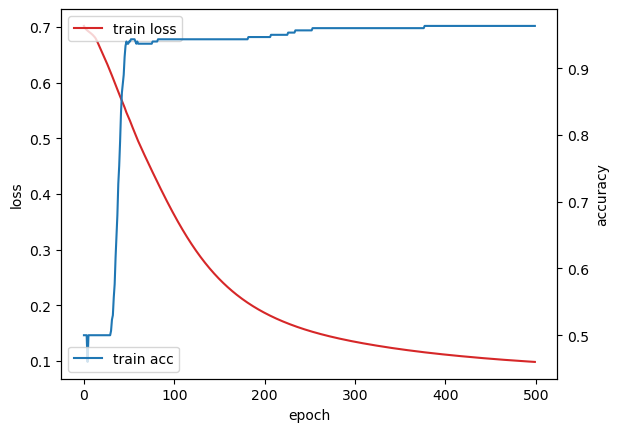

In [14]:
# 학습 과정 확인(Loss, Accuracy)
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], label='train loss', color = "tab:red")
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], label='train acc', color = "tab:blue")
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()

In [15]:
Loss, Accuracy = CNN_model.evaluate(ValidData,  ValidLabel, verbose=0)

print('Validation Accuracy: {:.2f}%'.format(Accuracy*100))

Validation Accuracy: 93.33%


In [16]:
# 모델 저장
CNN_model.save('./MLmodels/1DCNN_model.keras')

## CNN model 불러와서 진단

In [17]:
# 모델 불러오기
LoadedModel = keras.models.load_model('./MLmodels/1DCNN_model.keras')

In [18]:
Loss, Accuracy = LoadedModel.evaluate(ValidData,  ValidLabel, verbose=0)

print('[Performance of CNN model] \n')
print('Accuracy : {:.2f}%'.format(Accuracy*100))

[Performance of CNN model] 

Accuracy : 93.33%


## ++. Confusion Matrix 확인

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [20]:
# 분류 결과 확인
Pred = LoadedModel.predict(ValidData)
pd.DataFrame(Pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


,0,1
0,0.998737,1.263017e-03
1,0.996044,3.956261e-03
2,0.564107,4.358931e-01
3,0.877816,1.221843e-01
4,0.804184,1.958157e-01
5,0.529688,4.703124e-01
6,1.000000,4.961537e-37
7,0.978656,2.134427e-02
8,0.976707,2.329328e-02
9,0.874151,1.258489e-01


In [21]:
# One-hot encoding -> Label encoding
true = np.argmax(ValidLabel, axis=-1)
pred = np.argmax(Pred, axis=-1)

# Confusion Matrix 생성
CM = confusion_matrix(true, pred).T

# 데이터의 실제/분류결과 이름
x = ['Normal_True', 'Abnormal_True']
y = ['Normal_Pred', 'Abnormal_Pred']

CM_df = pd.DataFrame(CM,columns=x, index=y)
CM_df

,Normal_True,Abnormal_True
Normal_Pred,27,1
Abnormal_Pred,3,29


C:\Users\BJ\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


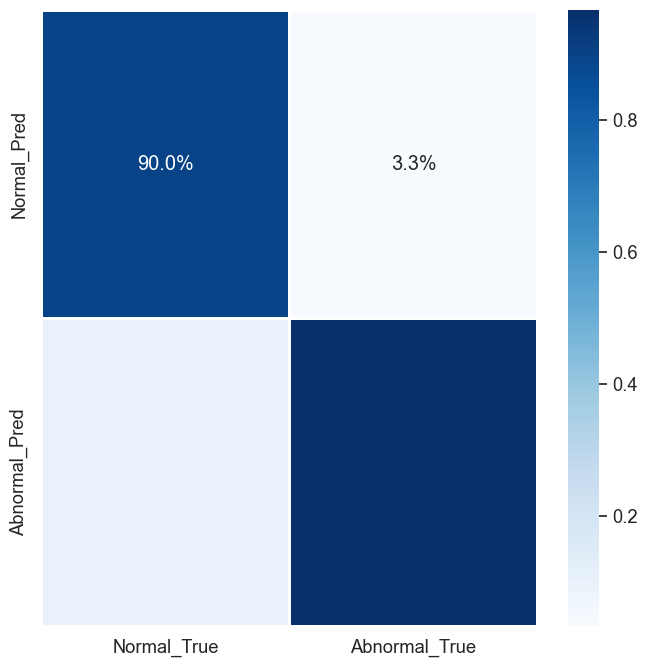

In [22]:
# heatmap font size
sns.set(font_scale=1.2)

# Heatmap 형태로 확인
fig = plt.subplots(figsize=(8,8))


# 퍼센트
sns.heatmap(CM_df/np.sum(CM_df),
            cmap='Blues',          # cmap Color
            annot=True,            # Value Text
            fmt=".1%",             # Value type (integer = "d")
            linewidths=2)

# 갯수
# sns.heatmap(CM_df,
#             cmap='Blues',        # cmap Color
#             annot=True,          # Value Text
#             fmt="d",             # Value type (integer = "d")
#             linewidths=2) 



plt.show()